In [ ]:
# Import packages
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [2]:
# Load the data
df2021 = pd.read_csv('data/shelter/daily-shelter-overnight-service-occupancy-capacity-2021.csv')
df2022 = pd.read_csv('data/shelter/daily-shelter-overnight-service-occupancy-capacity-2022.csv')
df2023 = pd.read_csv('data/shelter/daily-shelter-overnight-occupancy.csv') 

# Unify year format
df2021['OCCUPANCY_DATE'] = df2021['OCCUPANCY_DATE'].apply(lambda x: '2021' + x[2:] if x.startswith('21') else x)
df2022['OCCUPANCY_DATE'] = df2022['OCCUPANCY_DATE'].apply(lambda x: '2022' + x[2:] if x.startswith('22') else x)

# Concatenate the dataframes
df = pd.concat([df2021, df2022, df2023], ignore_index=True)

# Process date column
df["OCCUPANCY_DATE"] = pd.to_datetime(df["OCCUPANCY_DATE"])
df["year"] = df["OCCUPANCY_DATE"].dt.year
df["month"] = df["OCCUPANCY_DATE"].dt.month
df["day"] = df["OCCUPANCY_DATE"].dt.day
df = df.drop(columns=["OCCUPANCY_DATE"])

# Get occupancy rate
df['OCCUPANCY_RATE'] = np.where(df['CAPACITY_TYPE'] == 'Bed Based Capacity', df['OCCUPANCY_RATE_BEDS'], np.where(df['CAPACITY_TYPE'] == 'Room Based Capacity', df['OCCUPANCY_RATE_ROOMS'], np.nan))

# Drop columns that are not useful
df = df.drop(
    columns=[
        "ORGANIZATION_NAME",
        "SHELTER_GROUP",
        "LOCATION_NAME",
        "LOCATION_ADDRESS",
        "LOCATION_POSTAL_CODE",
        "LOCATION_CITY",
        "LOCATION_PROVINCE",
        "PROGRAM_NAME",
        "CAPACITY_ACTUAL_BED",
        "CAPACITY_FUNDING_BED",
        "OCCUPIED_BEDS",
        "UNOCCUPIED_BEDS",
        "UNAVAILABLE_BEDS",
        "CAPACITY_TYPE",
        "CAPACITY_ACTUAL_ROOM",
        "CAPACITY_FUNDING_ROOM",
        "OCCUPIED_ROOMS",
        "UNOCCUPIED_ROOMS",
        "UNAVAILABLE_ROOMS",
        "OCCUPANCY_RATE_BEDS",
        "OCCUPANCY_RATE_ROOMS",
    ]
)

In [3]:
# Combine year, month, and day into a single date column
df['ds'] = pd.to_datetime(df[['year', 'month', 'day']])

# Rename the occupancy rate column to 'y' to comply with Prophet's naming convention
df = df.rename(columns={'OCCUPANCY_RATE': 'y'})

# Drop the year, month, and day columns as they are no longer needed
df = df.drop(columns=['year', 'month', 'day'])

In [4]:
# Set the cap and floor for logistic growth
df['cap'] = 1.0
df['floor'] = 0.0

In [5]:
# Get a list of unique shelter IDs
shelter_ids = df['SHELTER_ID'].unique()

# Dictionary to store the forecasts
forecasts_dict = {}

for shelter_id in shelter_ids:
    # Filter the data for the current shelter
    shelter_data = df[df['SHELTER_ID'] == shelter_id]
    
    # Drop the SHELTER_ID column as it's not needed for modeling
    shelter_data = shelter_data.drop(columns=['SHELTER_ID'])
    
    # Create and fit the Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(shelter_data)
    
    # Create future dates for prediction
    future = model.make_future_dataframe(periods=365)  # Predict the next year
    future['cap'] = 1.0
    future['floor'] = 0.0
    
    
    # Make predictions
    forecast = model.predict(future)
    
    # Store the forecast in the dictionary
    forecasts_dict[shelter_id] = forecast



00:27:41 - cmdstanpy - INFO - Chain [1] start processing
00:27:42 - cmdstanpy - INFO - Chain [1] done processing
00:27:42 - cmdstanpy - INFO - Chain [1] start processing
00:27:43 - cmdstanpy - INFO - Chain [1] done processing
00:27:43 - cmdstanpy - INFO - Chain [1] start processing
00:27:43 - cmdstanpy - INFO - Chain [1] done processing
00:27:43 - cmdstanpy - INFO - Chain [1] start processing
00:27:44 - cmdstanpy - INFO - Chain [1] done processing
00:27:44 - cmdstanpy - INFO - Chain [1] start processing
00:27:44 - cmdstanpy - INFO - Chain [1] done processing
00:27:44 - cmdstanpy - INFO - Chain [1] start processing
00:27:44 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:46 - cmdstanpy - INFO - Chain [1] start processing
00:27:46 - cmdstanpy - INFO - Chain [1]

00:28:16 - cmdstanpy - INFO - Chain [1] start processing
00:28:16 - cmdstanpy - INFO - Chain [1] done processing


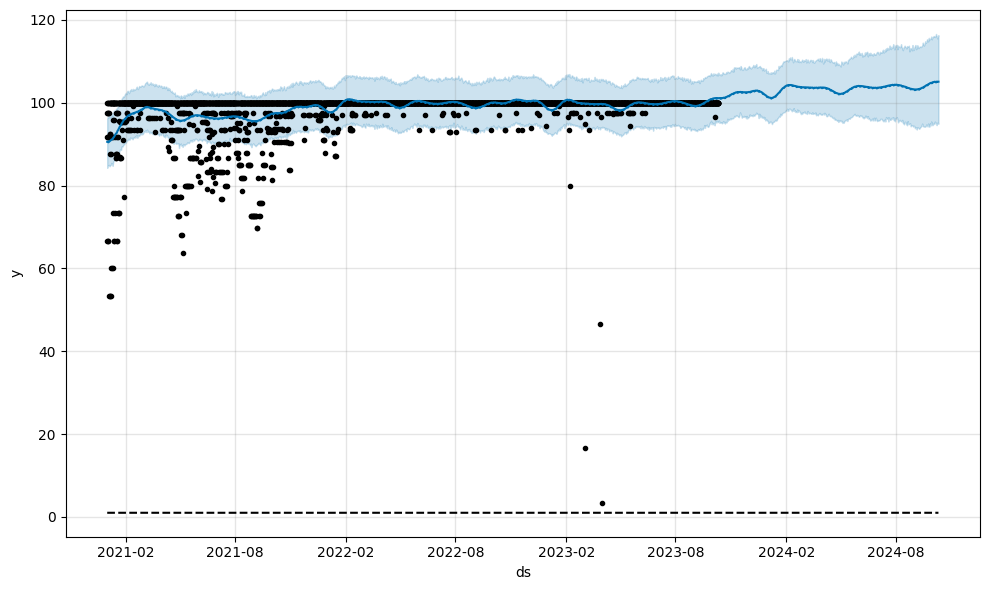

In [6]:
forecast_22 = forecasts_dict[22]
model_22 = Prophet(growth='logistic', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_22.fit(df[df['SHELTER_ID'] == 22].drop(columns=['SHELTER_ID']))
fig_22 = model_22.plot(forecast_22)

# Show the plot
plt.show()

In [7]:
forecasts_dict[20]

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,87.269100,1.0,64.746556,104.476051,87.269100,87.269100,-2.135781,-2.135781,-2.135781,-0.191034,-0.191034,-0.191034,-1.944748,-1.944748,-1.944748,0.0,0.0,0.0,85.133319
1,2021-01-02,87.274662,1.0,65.151934,106.152736,87.274662,87.274662,-1.536914,-1.536914,-1.536914,0.091598,0.091598,0.091598,-1.628512,-1.628512,-1.628512,0.0,0.0,0.0,85.737748
2,2021-01-03,87.280225,1.0,64.012498,104.471708,87.280225,87.280225,-1.579257,-1.579257,-1.579257,-0.286196,-0.286196,-0.286196,-1.293061,-1.293061,-1.293061,0.0,0.0,0.0,85.700968
3,2021-01-04,87.285787,1.0,65.887353,105.950396,87.285787,87.285787,-1.077336,-1.077336,-1.077336,-0.133738,-0.133738,-0.133738,-0.943598,-0.943598,-0.943598,0.0,0.0,0.0,86.208452
4,2021-01-05,87.291350,1.0,66.546512,107.078749,87.291350,87.291350,-0.363685,-0.363685,-0.363685,0.221793,0.221793,0.221793,-0.585478,-0.585478,-0.585478,0.0,0.0,0.0,86.927665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,2024-10-06,90.371842,1.0,68.316098,108.407275,88.795660,91.813489,-1.874852,-1.874852,-1.874852,-0.286196,-0.286196,-0.286196,-1.588656,-1.588656,-1.588656,0.0,0.0,0.0,88.496990
1375,2024-10-07,90.367009,1.0,67.907392,108.741777,88.781452,91.812962,-1.368101,-1.368101,-1.368101,-0.133738,-0.133738,-0.133738,-1.234363,-1.234363,-1.234363,0.0,0.0,0.0,88.998909
1376,2024-10-08,90.362177,1.0,69.123840,109.424230,88.767475,91.814317,-0.625119,-0.625119,-0.625119,0.221793,0.221793,0.221793,-0.846913,-0.846913,-0.846913,0.0,0.0,0.0,89.737058
1377,2024-10-09,90.357345,1.0,69.352066,109.580813,88.754980,91.818548,0.163049,0.163049,0.163049,0.597192,0.597192,0.597192,-0.434143,-0.434143,-0.434143,0.0,0.0,0.0,90.520394


00:28:21 - cmdstanpy - INFO - Chain [1] start processing
00:28:21 - cmdstanpy - INFO - Chain [1] done processing


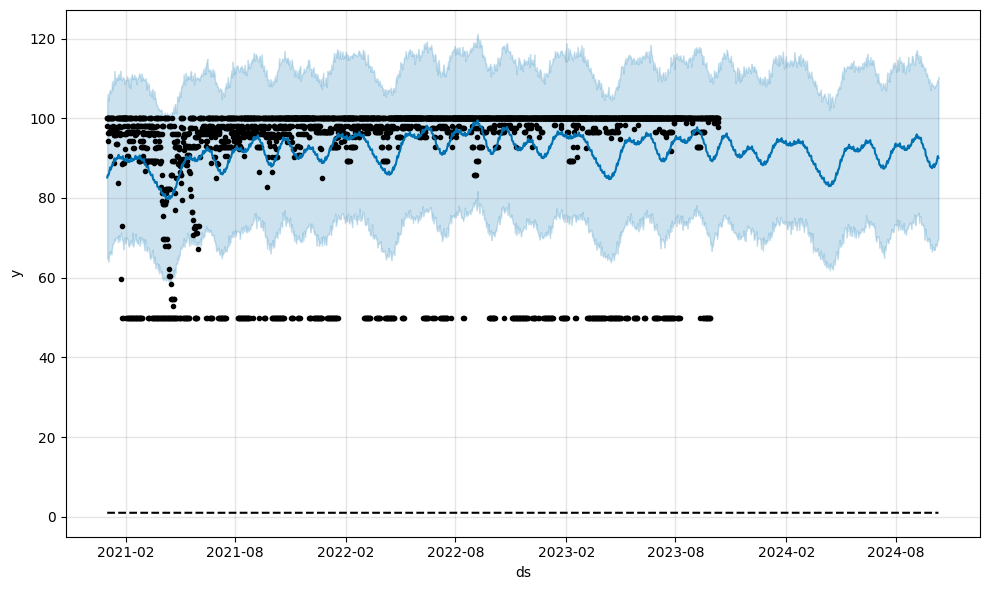

In [8]:
forecast_20 = forecasts_dict[20]
model_20 = Prophet(growth='logistic', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_20.fit(df[df['SHELTER_ID'] == 20].drop(columns=['SHELTER_ID']))
fig_20 = model_20.plot(forecast_20)

# Show the plot
plt.show()